# Quantum Teleportation

#### Alice wants to send a secret state $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$ to Bob.
#### Alice doesn't know the state and can only send classical information to Bob

### Import section

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import *
import numpy as np
from math import pi

from qiskit_aer import StatevectorSimulator, QasmSimulator, UnitarySimulator
import numpy as np
from math import pi

### Function to apply a secret unitary

In [2]:
# simple function that applies a series of unitary gates from a given string
def apply_secret_unitary(secret_unitary, qubit, quantum_circuit, dagger):
    functionmap = {
                    'x':quantum_circuit.x,
                    'y':quantum_circuit.y,
                    'z':quantum_circuit.z,
                    'h':quantum_circuit.h,
                    't':quantum_circuit.t,
    }
    if dagger: functionmap['t'] = quantum_circuit.tdg
    if dagger:
        [functionmap[unitary](qubit) for unitary in secret_unitary]
    else:
        [functionmap[unitary](qubit) for unitary in secret_unitary[::-1]]

### 1. Generate the secret state to teleport

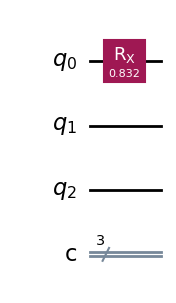

Statevector([0.91475432+0.j        , 0.        -0.40401056j,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2))


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

In [3]:
qc = QuantumCircuit(3,3)

theta = pi*np.random.uniform()
qc.rx(theta,0)

display(qc.draw('mpl'))
backend = StatevectorSimulator()
job = backend.run(qc).result()
display(job.get_statevector())

# Show it on a Bloch sphere
#plot_bloch_multivector(psi)

qc.barrier()

In [4]:
theta/pi

0.26476820333590023

### 2. Generate the entangled pair shared by Alice and Bob

In [5]:
qc.h(1)
qc.cx(1,2)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

#### The output state is now $\sqrt{2} |\psi_o\rangle = (\alpha|0\rangle + \beta |1\rangle) (|00\rangle+|11\rangle) = \alpha|000\rangle + \alpha |011\rangle + \beta|100\rangle + \beta |111\rangle$

### 3. Teleportation protocol (on Alice's qubits)

In [6]:
qc.cx(0,1) 
qc.h(0)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

#### The output state is now $2 |\psi_o\rangle = |00\rangle (\alpha|0\rangle+\beta|1\rangle) + |01\rangle (\alpha|1\rangle+\beta|0\rangle) + |10\rangle (\alpha|0\rangle-\beta|1\rangle) + |11\rangle (\alpha|1\rangle-\beta|0\rangle)$

### 4. Measurement and  operation depending on the outcome

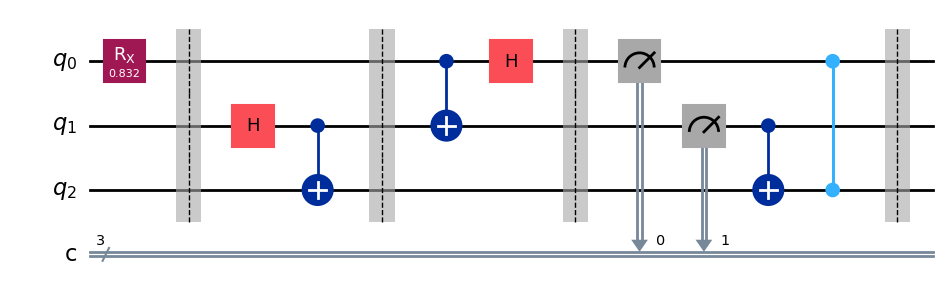

In [7]:
qc.measure(0, 0)
qc.measure(1, 1)
qc.cx(1, 2)
qc.cz(0, 2)
qc.barrier()

qc.draw('mpl')

### Bob should recover the state sent by Alice, or $|0\rangle$ if we apply $U_{secret}^{\dagger}$

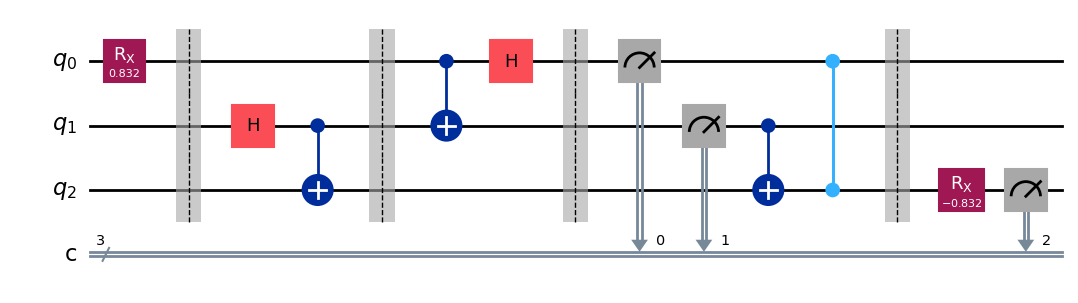

In [8]:
#apply_secret_unitary(secret_unitary, qc.qubits[2], qc, dagger=1)
qc.rx(-theta,2)
qc.measure(2, 2)
qc.draw('mpl')

{'000': 1}


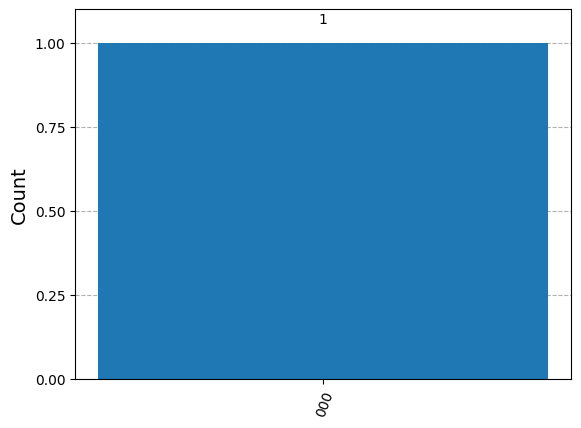

In [9]:
backend = QasmSimulator()
counts = backend.run(qc,shots = 1).result().get_counts()
print(counts)
plot_histogram(counts)

#### Bob finds correctly $|0\rangle$ (remember that qubits are reodered from right to left)

## Implementation on the real hardware

#### On the real hardware we cannot perform operations conditioned by the results of previous measurements

#### We can however exploit the "deferred measurement principle": the circuit is the same as before, with measurements postponed to conditional operations

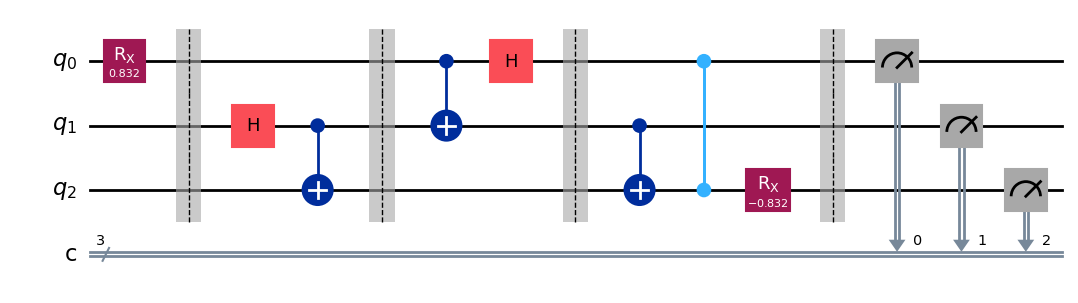

In [18]:
qc = QuantumCircuit(3,3)

#apply_secret_unitary(secret_unitary, qc.qubits[0], qc, dagger = 0)
qc.rx(theta,0)
qc.barrier()
# Generate the entangled pair
qc.h(1)
qc.cx(1,2)
qc.barrier()
# Apply the teleportation protocol.
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.cx(1,2)
qc.cz(0,2)
#apply_secret_unitary(secret_unitary, qc.qubits[2], qc, dagger=1)
qc.rx(-theta,2)
# Measure only Ale's qubit
qc.barrier()
qc.measure(0,0)
qc.measure(1,1)
qc.measure(2,2)

qc.draw(output='mpl')

#### Let's chek this works on the simulator

{'001': 1}


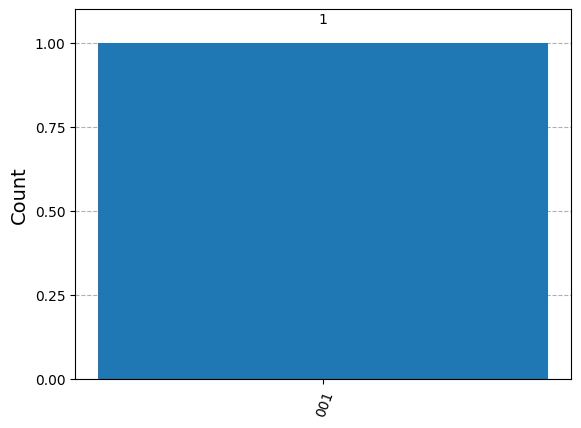

In [20]:
backend = QasmSimulator()
counts = backend.run(qc,shots = 1).result().get_counts()
print(counts)
plot_histogram(counts)

#### Let's now try on the real hardware

In [34]:
# First, see what devices we are allowed to use by loading our saved accounts

# è necessario creare un account ed aggiornare il token 

token = "xxx"

service = QiskitRuntimeService(channel='ibm_quantum',token=token)
service.backends()

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

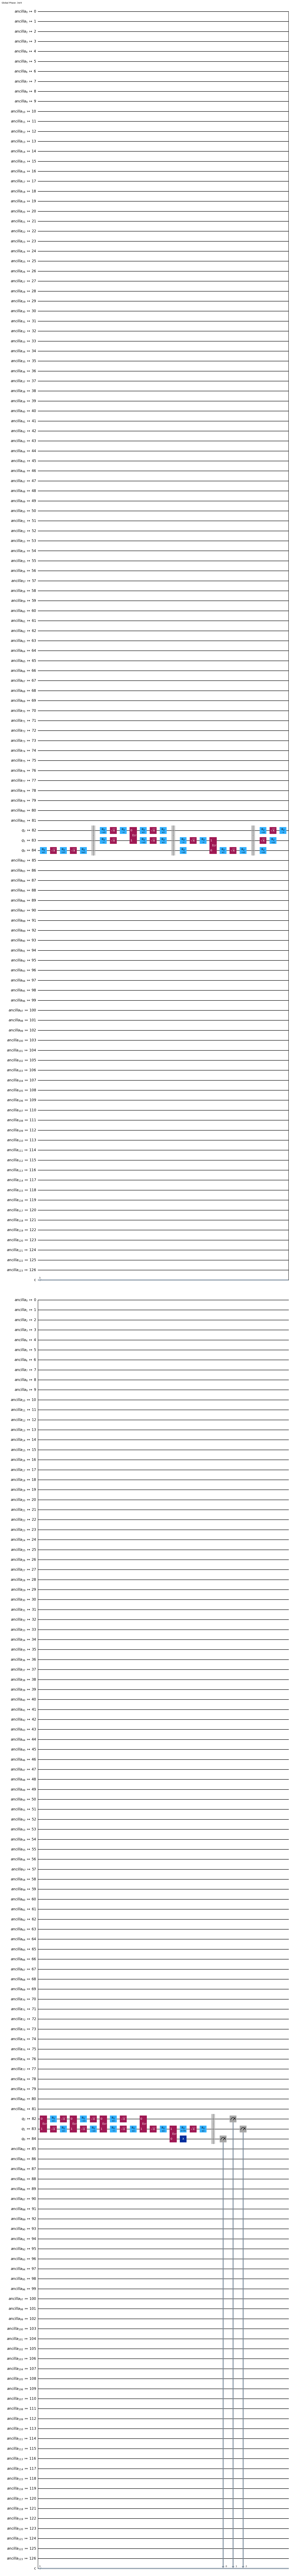

gates =  OrderedDict([('rz', 29), ('sx', 18), ('ecr', 7), ('barrier', 4), ('measure', 3), ('x', 1)])
depth =  40


/tmp/ipykernel_419/3213471026.py:13: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(qc,shots = 8192)
/tmp/ipykernel_419/3213471026.py:15: DeprecationWarning: In a future release of qiskit-ibm-runtime no sooner than 3 months after the release date of 0.30.0, RuntimeJob.status() will be returned as a string instead of an instance of `JobStatus`.
  job.status()


<JobStatus.QUEUED: 'job is queued'>

In [32]:
# codice alternativo al blocco successivo dato che non tutte le macchine fornite da IBM supportano il cx

# Circuit 0: The instruction rx on qubits (0,) is not supported by the target system. -- \n Transpile your circuits for
# the target before submitting a primitive query.\n Refer to\n `Primitives examples <https://docs.quantum.ibm.com/guides/primitives-examples>`_\n
# for code examples.\n -- https://ibm.biz/error_codes#1517

from qiskit.visualization import plot_circuit_layout

backend = service.backend('ibm_brisbane')

new_circ_lv0 = transpile(qc, backend=backend, optimization_level=1)
# display(plot_circuit_layout(new_circ_lv0, backend))

display(new_circ_lv0.draw('mpl'))
print('gates = ', new_circ_lv0.count_ops())
print('depth = ', new_circ_lv0.depth())

job = backend.run(qc,shots = 8192)

job.status()

#### See info on how to run on the hardware at https://quantum-computing.ibm.com/docs/manage/

In [25]:
# get the least-busy backend at IBM and run the quantum circuit there

# scelgo quello con meno carico, che non sia un simulatore e sia attivo (non funziona)
# backend = service.least_busy(simulator=False,operational=True)

# scelgo un backend (deve essere tra quelli online)
backend = service.backend('ibm_brisbane')

# submit del job 
job = backend.run(qc,shots = 8192)

job.status()
#job_exp = execute(qc, backend=provider.get_backend('ibmq_lagos'), shots=8192)

/tmp/ipykernel_419/3321777014.py:10: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(qc,shots = 8192)
/tmp/ipykernel_419/3321777014.py:12: DeprecationWarning: In a future release of qiskit-ibm-runtime no sooner than 3 months after the release date of 0.30.0, RuntimeJob.status() will be returned as a string instead of an instance of `JobStatus`.
  job.status()


<JobStatus.QUEUED: 'job is queued'>

In [26]:
# check job status
job.status()

counts = job.result().get_counts()
print(counts)
plot_histogram(counts)

/tmp/ipykernel_419/2652413130.py:2: DeprecationWarning: In a future release of qiskit-ibm-runtime no sooner than 3 months after the release date of 0.30.0, RuntimeJob.status() will be returned as a string instead of an instance of `JobStatus`.
  job.status()


RuntimeJobFailureError: 'Unable to retrieve job result. Error code 1517; Circuit 0: The instruction rx on qubits (0,) is not supported by the target system. -- \\n        Transpile your circuits for the target before submitting a primitive query.\\n        Refer to\\n        `Primitives examples <https://docs.quantum.ibm.com/guides/primitives-examples>`_\\n        for code examples.\\n         -- https://ibm.biz/error_codes#1517'

In [ ]:
correct_results = exp_result.get_counts(qc)['000'] + exp_result.get_counts(qc)['010'] + exp_result.get_counts(qc)['100'] + exp_result.get_counts(qc)['110']
accuracy = (correct_results/float(8192))*100
print("Accuracy = %.2f%%" % accuracy)